In this notebook, we:
- Tune a Gabor filter to enhance cracks
- Apply this filter to all images
- Concatenate the filtered images with the unfiltered images
- Train a convolutional neural network against the result

### Import the libraries

In [1]:
from os import environ
environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Deactive warnings about building from source

from scipy.misc import imread, imresize
from datetime import datetime
from os.path import exists
from shutil import rmtree
from os import makedirs
import tensorflow as tf
from glob import glob
import numpy as np

from models import two_layer_convnet_with_batch_normalization
from pymvtest import classification

from skimage.filters import sobel_h, sobel_v
from skimage.filters import gabor_kernel
from scipy.signal import convolve

import matplotlib.pyplot as plt
%matplotlib inline

### Import the data

In [2]:
print('Importing data...')

# Whiten on import
images = np.array([np.expand_dims(imread(fp), axis = -1)
                  for fp in glob('./data/resized-images/*.png')])
masks  = np.array([imread(fp)/255 for fp in glob('./data/masked-images/*.png')])
print('Data imported.')

Importing data...
Data imported.


### Define the filter

C:\Users\admin\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  return out.astype(volume.dtype)


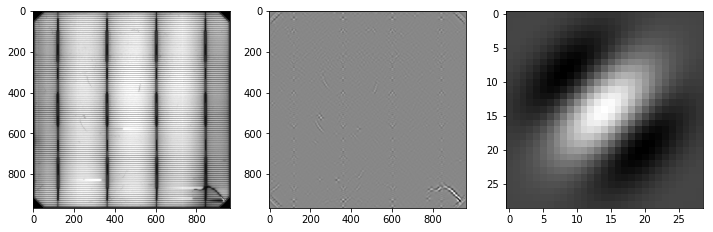

In [3]:
def _filter(image):
    if len(image.shape) == 3: image = image.squeeze()
    K = gabor_kernel(frequency = 0.05, theta = np.pi/4, bandwidth = 2)
    image = sobel_h(image)
    image = sobel_v(image)
    re_l = np.real(convolve(image, K, mode = 'same'))
    re_r = np.real(convolve(image, np.flip(K, axis=0), mode = 'same'))
    image   = re_l - re_r
    return np.expand_dims(image, axis = -1)

K = gabor_kernel(frequency = 0.05, theta = np.pi/4, bandwidth = 2)

f, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(images[14, :, :, 0], cmap = 'gray')
axs[1].imshow(_filter(images[14, :, :, 0])[:, :, 0], cmap = 'gray')
axs[2].imshow(np.real(K), cmap = 'gray');

### Apply the filter to the images

In [4]:
print('Filtering images...')
images = np.array([np.concatenate([img, _filter(img)], axis = 2) for img in images])
print('Images filtered and stacked.')

Filtering images...


C:\Users\admin\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  return out.astype(volume.dtype)


Images filtered and stacked.


### Define the master dictionary
*controls network architecture and hyperparameters}

In [5]:
TF = {
      'batch_size':32,
      'graph':None,
      'image_size':200,
      'patch_size':20,
      'input_channels':2,
      'learning_rate':0.001,
      'n_classes':2,
      'output_channels':[16, 8, 32],
      'filter_size':[3, 5],
      'seed':3,
      'split_fraction':0.7,
      'summary_train':[],
      'summary_test':[],
      'training_steps':1001,
      'test_id':'002_Gabor_filtered',
}
print('Training for {} iterations.'.format(TF['training_steps']))
print('{} units per batch.'.format(TF['batch_size']))

Training for 1001 iterations.
32 units per batch.


### Prepare the data for training

In [6]:
print('Whitening and resizing images...')
# Whiten the images
eps = 1e-6
white_images = (images - np.mean(images, axis = 0))/(np.std(images, axis = 0)+eps)

# Resize the images
res_images, res_masks = classification.resize(white_images, masks, TF['image_size'])
print('Images whitened and resized.')

Whitening and resizing images...
Images whitened and resized.


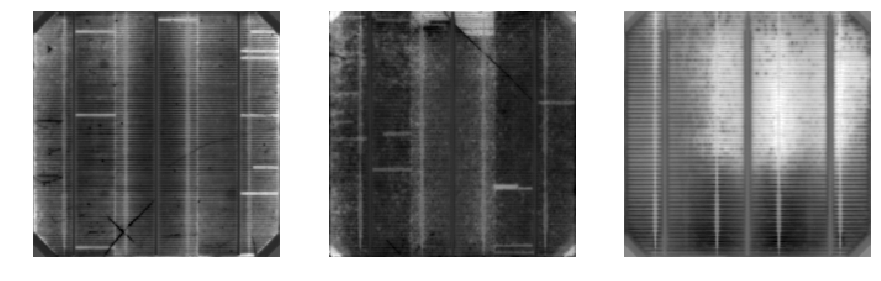

In [7]:
# Extract three images for testing, use the test for training/validation
query_ix      = np.array([(i == 8 or i == 18 or i == 22) for i in range(0, res_images.shape[0])])
train_ix      = np.logical_not(query_ix)
query_images  = res_images[query_ix, :, :, :]
query_masks   = res_masks[query_ix, :, :]
images        = res_images[train_ix, :, :, :]
masks         = res_masks[train_ix, :, :]

f, axs = plt.subplots(1, 3, figsize = (15, 5))
for i, ax in enumerate(axs):
    ax.imshow(query_images[i, :, :, 0], cmap = 'gray')
    ax.axis('off');

### Train a network against these images

In [8]:
# Get the graph
TF     = two_layer_convnet_with_batch_normalization.model(TF)

# Fit the model
tester = classification.Tester(res_images, res_masks, TF)
tester.fit_model()

Training dataset dimensions: (41, 200, 200, 2)
Validation dataset dimensions: (11, 200, 200, 2)

Fitting model...

(Step  100 ) Minibatch accuracy:     0.94
(Step  100 ) Minibatch loss:       0.2288
(Step  100 ) Validation accuracy:    0.70

(Step  200 ) Minibatch accuracy:     0.84
(Step  200 ) Minibatch loss:       0.3320
(Step  200 ) Validation accuracy:    0.91

(Step  300 ) Minibatch accuracy:     0.94
(Step  300 ) Minibatch loss:       0.1061
(Step  300 ) Validation accuracy:    0.93

(Step  400 ) Minibatch accuracy:     0.88
(Step  400 ) Minibatch loss:       0.2523
(Step  400 ) Validation accuracy:    0.55

(Step  500 ) Minibatch accuracy:     0.97
(Step  500 ) Minibatch loss:       0.1189
(Step  500 ) Validation accuracy:    0.93

(Step  600 ) Minibatch accuracy:     0.94
(Step  600 ) Minibatch loss:       0.1215
(Step  600 ) Validation accuracy:    0.94

(Step  700 ) Minibatch accuracy:     1.00
(Step  700 ) Minibatch loss:       0.0477
(Step  700 ) Validation accuracy:    0.

### Evaluate the model's performance

In [9]:
# Query the model
predictions, query_masks = tester.query_model(query_images, query_masks)

INFO:tensorflow:Restoring parameters from ./checkpoints/002_Gabor_filtered.ckpt


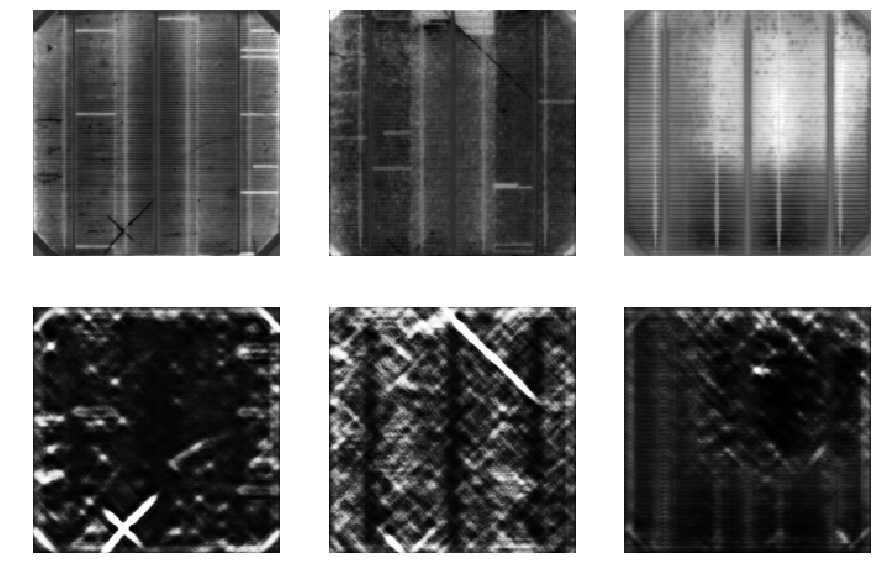

In [10]:
f, axs = plt.subplots(2, 3, figsize = (15, 10))
for i, ax in enumerate(axs.flatten()):
    if i < 3:
        ax.imshow(query_images[i, :, :, 0], cmap = 'gray')
        ax.axis('off');
    if i >= 3:
        ax.imshow(predictions[i-3, :, :], cmap = 'gray')
        ax.axis('off');